# Simulated Annealing

We will be trying to find and visualize the path between Equestrian Statue of Edward VII and Bahen Center of Technology around Toronto University campus using simulated annealing

In [ ]:
%%capture

##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes
!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;

# you HAVE to upload a number of files and folders used in the code
# problem.py - utils.py - data files inside directory named data
# upload them in the home directory --- don't go into any folder, just press upload button
# and choose these files and folders
# so tthe directory should be 
#|- data/       |- graph.html
#|              |- route.html 
#|- sample_data/ 
#|- problem.py
#|- utils.py

In [1]:
import osmnx as ox
import networkx as nx
from IPython.display import IFrame, HTML
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
import sys, random
from problem import *
from utils import *

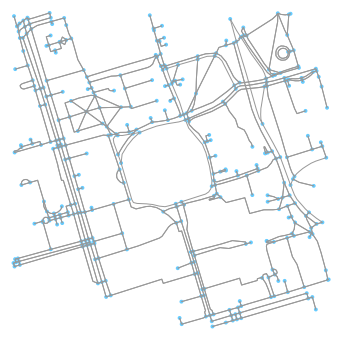

In [2]:
location_point = (43.661667, -79.395)
G = ox.graph_from_point(location_point, dist=300, clean_periphery=True, simplify=True)
graph_map = ox.plot_graph_folium(G, popup_attribute='name', edge_width=2)
fig, ax = ox.plot_graph(G)

In [3]:
# we need to save the graph 
filepath = 'data/graph.html'
graph_map.save(filepath)
IFrame(filepath, width=600, height=500)

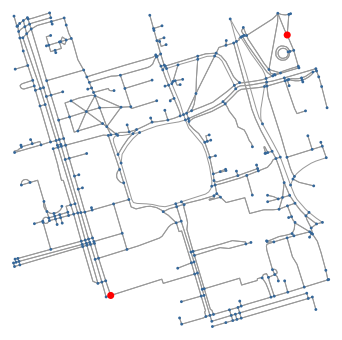

In [4]:
# marking both the source and destination node

nc = ['r' if node == 389677909 or node == 55808290 else '#336699' for node in G.nodes()]
ns = [50 if node == 389677909 or node == 55808290 else 8 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_size=ns, node_color=nc, node_zorder=2)

## The Algorithm

__SIMULATED-ANNEALING__(graph, schedule) __returns__ a solution state  
&emsp;_current_ &larr; _source-node_  
&emsp;__for__ _t_ &larr; __to__ $\inf$  
&emsp;&emsp; _T_ &larr; _schedule(t)_  
&emsp;&emsp; __if__ _current_ __is__ _destination_ __then__ __return__ _current_.PATH  
&emsp;&emsp; __if__ _T_ = 0 __then__ __return__ _current_.PATH  
&emsp;&emsp; _neighbors_ &larr; _current_.SUCCESSORS  
&emsp;&emsp; _next_ &larr; randomly choose one state from _neighbors_  
&emsp;&emsp; _$\Delta$_ _E_ &larr; _next_._COST_ - _current_._COST_  
&emsp;&emsp; __if__ _$\Delta$_ _E_ &lt; 0 __then__ _current_ &larr; _next_    
&emsp;&emsp; __else__ _current_ &larr; _next_ only with probability of ${e}^{\frac{\Delta E}{T}}$  
&emsp;__endfor__

In [5]:
%%capture
source(Node)

The tough part here is to about generating neighbors and paths from the source to destination. Generating all simple paths from a given two distinct vertices is NP problem because in a complete graph for example the number of paths is $O(n!)$ which gets out of hand after having 10-12 nodes in the graph if you enumerate them all.  

What we can do, *for now*, is using a simple path finding algorithm and add randomization to it to generate many distinct paths in the map. We can generate random permuation but the map is not complete so we cannot be sure that the generated permutation is an actual path in the map without much trouble.  

We will do randomized BFS to generate any number of distinct paths.

In [10]:
def randomized_BFS(G, source, destination, nums_of_paths = 1):
    origin = Node(graph = G, node = G[source], osmid = source, distance = 0, parent = None)
    destination = Node(graph = G, node = G[destination], osmid = destination)
    nums = nums_of_paths
    routes = list()
    while nums > 0:
        route = []
        frontier = deque([origin])
        explored = set()
        found = False
        while frontier and not found:
            node = random.choice(frontier)   # here is the randomization part
            frontier.remove(node)
            explored.add(node)
            for child in node.expand():
                if child not in explored and child not in frontier:
                    if child == destination:
                        route, cost = child.path()
                        routes.append((route, cost))
                        found = True
                    frontier.append(child)
        nums -= 1
    return routes

The default of the schedule function is that the initial temperature is 20 and it gets terminated after 100 unit time.

In [15]:
source(exp_schedule)

In [16]:
schedule = exp_schedule(k=2000,lam=0.05, limit=10000)

In [17]:
origin = Node(graph = G, node = G[55808290], osmid = 55808290, distance = 0, parent = None)
destination = Node(graph = G, node = G[389677909], osmid = 389677909)

In [36]:
states = []
# the function returns a **list** of (route, cost)
current = randomized_BFS(G, 55808290, 389677909, nums_of_paths=1)[0] 
for t in range(sys.maxsize):
    T = schedule(t)
    if T < 0.01:
        route, cost = current
        break
    # generate 5 more paths to choose from
    neighbors = randomized_BFS(G, 55808290, 389677909, nums_of_paths=5)
    next_choice = random.choice(neighbors)
    delta_e = next_choice[1] - current[1]  # difference of cost
    if delta_e < 0 or probability(np.exp(delta_e)/T): # getting closer to the goal
        current = next_choice

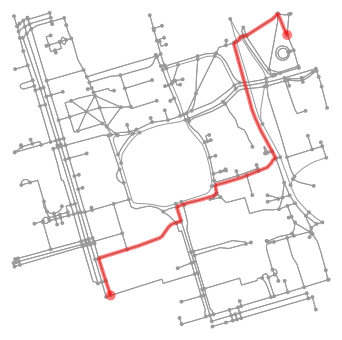

In [37]:
fig, ax = ox.plot_graph_route(G, route)

A* search gets 838.92 cost and dijkstra gets 832.2 so getting 900-ish as cost would be very good.

In [38]:
cost

887.1749999999998